# Pokémon battles — XGBoost with 10-fold outer CV + Grid Search
Notebook breve che esegue: feature engineering, split train/val/test, 10-fold outer CV con GridSearchCV interno, valutazione per fold, valutazione su holdout e generazione submission.csv.

In [52]:
import json
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# --- Percorsi (modificare se necessario) ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
train_file_path = 'train.jsonl'
test_file_path = 'test.jsonl'

def load_jsonl(path):
    data = []
    with open(path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

print('Caricamento dati...')
train_raw = load_jsonl(train_file_path)
test_raw = load_jsonl(test_file_path)
print(f'Train records: {len(train_raw)}, Test records: {len(test_raw)}')

Caricamento dati...
Train records: 10000, Test records: 5000
Train records: 10000, Test records: 5000


In [53]:
import math
from collections import Counter

# === TYPE CHART (Gen 1) ===
TYPE_CHART = {
    'normal': {'rock': 0.5, 'ghost': 0},
    'fire': {'fire': 0.5, 'water': 0.5, 'grass': 2, 'ice': 2, 'bug': 2, 'rock': 0.5, 'dragon': 0.5},
    'water': {'fire': 2, 'water': 0.5, 'grass': 0.5, 'ground': 2, 'rock': 2, 'dragon': 0.5},
    'grass': {'fire': 0.5, 'water': 2, 'grass': 0.5, 'poison': 0.5, 'ground': 2, 'flying': 0.5, 'bug': 0.5, 'rock': 2, 'dragon': 0.5},
    'electric': {'water': 2, 'grass': 0.5, 'electric': 0.5, 'ground': 0, 'flying': 2, 'dragon': 0.5},
    'ice': {'fire': 0.5, 'water': 0.5, 'grass': 2, 'ground': 2, 'flying': 2, 'dragon': 2},
    'fighting': {'normal': 2, 'ice': 2, 'poison': 0.5, 'flying': 0.5, 'psychic': 0.5, 'bug': 0.5, 'rock': 2, 'ghost': 0},
    'poison': {'grass': 2, 'poison': 0.5, 'ground': 0.5, 'bug': 2, 'rock': 0.5, 'ghost': 0.5},
    'ground': {'fire': 2, 'grass': 0.5, 'electric': 2, 'poison': 2, 'flying': 0, 'bug': 0.5, 'rock': 2},
    'flying': {'grass': 2, 'electric': 0.5, 'fighting': 2, 'bug': 2, 'rock': 0.5},
    'psychic': {'fighting': 2, 'poison': 2, 'psychic': 0.5, 'ghost': 0},
    'bug': {'fire': 0.5, 'grass': 2, 'fighting': 0.5, 'poison': 2, 'flying': 0.5, 'psychic': 2, 'ghost': 0.5},
    'rock': {'fire': 2, 'ice': 2, 'fighting': 0.5, 'ground': 0.5, 'flying': 2, 'bug': 2},
    'ghost': {'normal': 0, 'psychic': 0, 'ghost': 2},
    'dragon': {'dragon': 2}
}

def get_effectiveness(attack_type: str, defense_types: list) -> float:
    if not attack_type or not defense_types:
        return 1.0
    eff = 1.0
    for d in defense_types:
        eff *= TYPE_CHART.get(attack_type, {}).get(d, 1.0)
    return eff

def calculate_type_advantage(team1: list, team2_lead: dict) -> dict:
    out = {'p1_vs_lead_avg_effectiveness': 0.0, 'p1_vs_lead_max_effectiveness': 0.0, 'p1_super_effective_options': 0}
    if not team1 or not team2_lead:
        return out
    lead_types = [t.lower() for t in team2_lead.get('types', [])]
    if not lead_types:
        return out
    effs = []
    for p in team1:
        p_types = [t.lower() for t in p.get('types', [])]
        max_eff = 0.0
        for pt in p_types:
            max_eff = max(max_eff, get_effectiveness(pt, lead_types))
        effs.append(max_eff)
    if not effs:
        return out
    out['p1_vs_lead_avg_effectiveness'] = float(np.mean(effs))
    out['p1_vs_lead_max_effectiveness'] = float(np.max(effs))
    out['p1_super_effective_options'] = int(sum(1 for e in effs if e >= 2))
    return out

def _entropy(counter: Counter) -> float:
    total = sum(counter.values())
    if total == 0:
        return 0.0
    ent = 0.0
    for v in counter.values():
        p = v / total
        if p > 0:
            ent -= p * math.log(p, 2)
    return ent

def team_aggregate_features(team: list, prefix: str = 'p1_') -> dict:
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    out = {}
    vals = {s: [] for s in stats}
    levels = []
    types_counter = Counter()
    names = []
    for p in team:
        names.append(p.get('name',''))
        for s in stats:
            vals[s].append(p.get(s, 0))
        levels.append(p.get('level', 0))
        for t in p.get('types', []):
            types_counter[t.lower()] += 1
    for s in stats:
        arr = np.array(vals[s], dtype=float)
        out[f'{prefix}{s}_sum'] = float(arr.sum())
        out[f'{prefix}{s}_mean'] = float(arr.mean())
        out[f'{prefix}{s}_max'] = float(arr.max())
        out[f'{prefix}{s}_min'] = float(arr.min())
        out[f'{prefix}{s}_std'] = float(arr.std())
    level_arr = np.array(levels, dtype=float)
    out[f'{prefix}level_mean'] = float(level_arr.mean()) if level_arr.size else 0.0
    out[f'{prefix}level_sum'] = float(level_arr.sum()) if level_arr.size else 0.0
    out[f'{prefix}n_unique_types'] = int(len(types_counter))
    common_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying']
    for t in common_types:
        out[f'{prefix}type_{t}_count'] = int(types_counter.get(t, 0))
    out[f'{prefix}lead_name'] = names[0] if names else ''
    out[f'{prefix}n_unique_names'] = int(len(set(names)))
    out[f'{prefix}type_entropy'] = float(_entropy(types_counter))
    spe_arr = np.array(vals['base_spe'], dtype=float)
    out[f'{prefix}spe_p25'] = float(np.percentile(spe_arr, 25)) if spe_arr.size else 0.0
    out[f'{prefix}spe_p50'] = float(np.percentile(spe_arr, 50)) if spe_arr.size else 0.0
    out[f'{prefix}spe_p75'] = float(np.percentile(spe_arr, 75)) if spe_arr.size else 0.0
    return out

def lead_vs_lead_features(p1_lead: dict, p2_lead: dict) -> dict:
    out = {}
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    for s in stats:
        out[f'lead_diff_{s}'] = float(p1_lead.get(s,0) - p2_lead.get(s,0))
    out['lead_speed_advantage'] = float(p1_lead.get('base_spe',0) - p2_lead.get('base_spe',0))
    p1_types = [t.lower() for t in p1_lead.get('types', [])]
    p2_types = [t.lower() for t in p2_lead.get('types', [])]
    max_eff = 0.0
    for pt in p1_types:
        max_eff = max(max_eff, get_effectiveness(pt, p2_types))
    out['lead_p1_vs_p2_effectiveness'] = float(max_eff)
    return out

def lead_aggregate_features(pokemon: dict, prefix: str = 'p2_lead_') -> dict:
    out = {}
    stats = ['base_hp','base_atk','base_def','base_spa','base_spd','base_spe']
    for s in stats:
        out[f'{prefix}{s}'] = float(pokemon.get(s,0))
    out[f'{prefix}level'] = int(pokemon.get('level',0))
    types = [x.lower() for x in pokemon.get('types', [])]
    common_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying']
    for t in common_types:
        out[f'{prefix}type_{t}'] = int(t in types)
    out[f'{prefix}name'] = pokemon.get('name','')
    out[f'{prefix}n_unique_types'] = int(len(set(types)))
    return out

def summary_from_timeline(timeline: list, p1_team: list) -> dict:
    out = {}
    if not timeline:
        return {'tl_p1_moves':0,'tl_p2_moves':0,'tl_p1_est_damage':0.0,'tl_p2_est_damage':0.0,'damage_diff':0.0}
    p1_moves = p2_moves = 0
    p1_damage = p2_damage = 0.0
    p1_last_active = p2_last_active = ''
    p1_last_hp = p2_last_hp = np.nan
    p1_fainted = p2_fainted = 0
    p1_fainted_names = set()
    p2_fainted_names = set()
    last_p1_hp = {}
    last_p2_hp = {}
    p1_comeback_kos = 0
    p2_comeback_kos = 0
    p1_inflicted_statuses = Counter()
    p2_inflicted_statuses = Counter()
    p1_pokemon_statuses = {}
    p2_pokemon_statuses = {}
    p1_move_type_counts = Counter()
    p2_move_type_counts = Counter()
    p1_damage_first2 = 0.0
    p2_damage_first2 = 0.0
    for turn in timeline[:30]:
        prev_p1_fainted, prev_p2_fainted = p1_fainted, p2_fainted
        p1_state = turn.get('p1_pokemon_state',{}) or {}
        p2_state = turn.get('p2_pokemon_state',{}) or {}
        if p1_state.get('name'):
            p1_last_active = p1_state.get('name')
        if p2_state.get('name'):
            p2_last_active = p2_state.get('name')
        if p1_state.get('fainted') and p1_state.get('name') not in p1_fainted_names:
            p1_fainted += 1
            p1_fainted_names.add(p1_state.get('name'))
        if p2_state.get('fainted') and p2_state.get('name') not in p2_fainted_names:
            p2_fainted += 1
            p2_fainted_names.add(p2_state.get('name'))
        p2_name, p2_hp = p2_state.get('name'), p2_state.get('hp_pct')
        if p2_name and p2_hp is not None:
            prev_hp = last_p2_hp.get(p2_name)
            if prev_hp is not None:
                delta = max(0.0, prev_hp - p2_hp)
                p1_damage += delta
                if turn.get('turn',999) <= 2:
                    p1_damage_first2 += delta
            last_p2_hp[p2_name] = p2_hp
        p1_name, p1_hp = p1_state.get('name'), p1_state.get('hp_pct')
        if p1_name and p1_hp is not None:
            prev_hp = last_p1_hp.get(p1_name)
            if prev_hp is not None:
                delta = max(0.0, prev_hp - p1_hp)
                p2_damage += delta
                if turn.get('turn',999) <= 2:
                    p2_damage_first2 += delta
            last_p1_hp[p1_name] = p1_hp
        damage_diff_so_far = p1_damage - p2_damage
        if p2_fainted > prev_p2_fainted and damage_diff_so_far < -1.0:
            p1_comeback_kos += 1
        if p1_fainted > prev_p1_fainted and damage_diff_so_far > 1.0:
            p2_comeback_kos += 1
        p2_status = p2_state.get('status')
        if p2_name and p2_status and p2_pokemon_statuses.get(p2_name) != p2_status:
            p1_inflicted_statuses[p2_status] += 1
            p2_pokemon_statuses[p2_name] = p2_status
        p1_status = p1_state.get('status')
        if p1_name and p1_status and p1_pokemon_statuses.get(p1_name) != p1_status:
            p2_inflicted_statuses[p1_status] += 1
            p1_pokemon_statuses[p1_name] = p1_status
        p1_move = turn.get('p1_move_details') or {}
        p2_move = turn.get('p2_move_details') or {}
        if p1_move and p1_move.get('type'):
            p1_move_type_counts[(p1_move.get('type') or '').lower()] += 1
        if p2_move and p2_move.get('type'):
            p2_move_type_counts[(p2_move.get('type') or '').lower()] += 1
        if turn.get('p1_move_details'):
            p1_moves += 1
        if turn.get('p2_move_details'):
            p2_moves += 1
        p1_last_hp = p1_state.get('hp_pct', np.nan)
        p2_last_hp = p2_state.get('hp_pct', np.nan)
    out['tl_p1_moves'] = int(p1_moves)
    out['tl_p2_moves'] = int(p2_moves)
    out['tl_p1_est_damage'] = float(p1_damage)
    out['tl_p2_est_damage'] = float(p2_damage)
    out['damage_diff'] = float(p1_damage - p2_damage)
    out['fainted_diff'] = int(p1_fainted - p2_fainted)
    out['tl_p1_last_hp'] = float(p1_last_hp) if not np.isnan(p1_last_hp) else 0.0
    out['tl_p2_last_hp'] = float(p2_last_hp) if not np.isnan(p2_last_hp) else 0.0
    out['tl_p1_last_active'] = p1_last_active
    out['tl_p2_last_active'] = p2_last_active
    if p1_team:
        p1_total_hp_sum = sum(p.get('base_hp',0) for p in p1_team)
        p1_avg_def = np.mean([p.get('base_def',0) for p in p1_team] or [0])
        p1_avg_spd = np.mean([p.get('base_spd',0) for p in p1_team] or [0])
        out['tl_p2_damage_vs_p1_hp_pool'] = float(p2_damage / (p1_total_hp_sum + 1e-6))
        out['tl_p1_defensive_endurance'] = float((p1_avg_def + p1_avg_spd) / (p2_damage + 1e-6))
    out['tl_p1_comeback_kos'] = int(p1_comeback_kos)
    out['tl_p2_comeback_kos'] = int(p2_comeback_kos)
    out['tl_comeback_kos_diff'] = int(p1_comeback_kos - p2_comeback_kos)
    common_statuses = ['brn','par','slp','frz','psn','tox']
    for status in common_statuses:
        out[f'tl_p1_inflicted_{status}_count'] = int(p1_inflicted_statuses.get(status,0))
        out[f'tl_p2_inflicted_{status}_count'] = int(p2_inflicted_statuses.get(status,0))
        out[f'tl_inflicted_{status}_diff'] = int(p1_inflicted_statuses.get(status,0) - p2_inflicted_statuses.get(status,0))
    common_move_types = ['normal','fire','water','electric','grass','psychic','ice','dragon','rock','ground','flying','ghost','bug','poison','fighting']
    for mt in common_move_types:
        out[f'tl_p1_move_type_{mt}_count'] = int(p1_move_type_counts.get(mt,0))
        out[f'tl_p2_move_type_{mt}_count'] = int(p2_move_type_counts.get(mt,0))
        out[f'tl_move_type_{mt}_count_diff'] = int(p1_move_type_counts.get(mt,0) - p2_move_type_counts.get(mt,0))
    out['tl_p1_damage_first2'] = float(p1_damage_first2)
    out['tl_p2_damage_first2'] = float(p2_damage_first2)
    out['tl_first2_damage_diff'] = float(p1_damage_first2 - p2_damage_first2)
    return out

def ability_features(team: list, prefix: str) -> dict:
    immunity_abilities = {'levitate':0,'volt_absorb':0,'water_absorb':0,'flash_fire':0}
    stat_drop_abilities = {'intimidate':0}
    weather_abilities = {'drought':0,'drizzle':0,'sand_stream':0}
    out = {}
    for pokemon in team:
        ability = (pokemon.get('ability','') or '').lower().replace(' ','_')
        if ability in immunity_abilities:
            immunity_abilities[ability] += 1
        if ability in stat_drop_abilities:
            stat_drop_abilities[ability] += 1
        if ability in weather_abilities:
            weather_abilities[ability] += 1
    for ability,count in immunity_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    for ability,count in stat_drop_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    for ability,count in weather_abilities.items():
        out[f'{prefix}ability_{ability}_count'] = int(count)
    out[f'{prefix}total_immunity_abilities'] = int(sum(immunity_abilities.values()))
    out[f'{prefix}total_stat_drop_abilities'] = int(sum(stat_drop_abilities.values()))
    return out

def prepare_record_features(record: dict, max_turns: int = 30) -> dict:
    out = {}
    out['battle_id'] = record.get('battle_id')
    if 'player_won' in record:
        out['player_won'] = int(bool(record.get('player_won')))
    p1_team = record.get('p1_team_details', [])
    out.update(team_aggregate_features(p1_team, prefix='p1_'))
    p2_lead = record.get('p2_lead_details', {})
    out.update(lead_aggregate_features(p2_lead, prefix='p2_lead_'))
    out.update(ability_features(p1_team, prefix='p1_'))
    p1_lead = p1_team[0] if p1_team else {}
    out.update(lead_vs_lead_features(p1_lead, p2_lead))
    out.update(ability_features([p2_lead], prefix='p2_lead_'))
    out['p1_intimidate_vs_lead'] = 1 if out.get('p1_ability_intimidate_count',0) > 0 else 0
    tl = record.get('battle_timeline', [])
    out.update(summary_from_timeline(tl[:max_turns], p1_team))
    out['team_hp_sum_minus_p2lead_hp'] = out.get('p1_base_hp_sum', 0) - out.get('p2_lead_base_hp', 0)
    out['team_spa_mean_minus_p2spa'] = out.get('p1_base_spa_mean', 0) - out.get('p2_lead_base_spa', 0)
    out['speed_advantage'] = out.get('p1_base_spe_sum', 0) - out.get('p2_lead_base_spe', 0)
    out['n_unique_types_diff'] = out.get('p1_n_unique_types', 0) - out.get('p2_lead_n_unique_types', 1)
    p1_moves = max(out.get('tl_p1_moves',1),1)
    p2_moves = max(out.get('tl_p2_moves',1),1)
    out['damage_per_turn_diff'] = (out.get('tl_p1_est_damage',0.0)/p1_moves) - (out.get('tl_p2_est_damage',0.0)/p2_moves)
    out['last_pair'] = f"{out.get('tl_p1_last_active','')}_VS_{out.get('tl_p2_last_active','')}"
    out.update(calculate_type_advantage(p1_team, p2_lead))
    p2_lead_bulk = out.get('p2_lead_base_def',1) + out.get('p2_lead_base_spd',1)
    out['p1_se_options_vs_lead_bulk'] = out.get('p1_super_effective_options',0) / (p2_lead_bulk + 1e-6)
    p2_team = record.get('p2_team_details', [])
    if p2_team:
        out.update(team_aggregate_features(p2_team, prefix='p2_'))
        out['team_hp_sum_diff'] = out.get('p1_base_hp_sum',0) - out.get('p2_base_hp_sum',0)
        out['team_spa_mean_diff'] = out.get('p1_base_spa_mean',0) - out.get('p2_base_spa_mean',0)
        out['team_spe_mean_diff'] = out.get('p1_base_spe_mean',0) - out.get('p2_base_spe_mean',0)
        out['n_unique_types_team_diff'] = out.get('p1_n_unique_types',0) - out.get('p2_n_unique_types',0)
    return out

def create_features_from_raw(data: list) -> pd.DataFrame:
    rows = []
    for b in tqdm(data, desc='FE'):
        try:
            feat = prepare_record_features(b, max_turns=30)
            if 'battle_id' not in feat:
                feat['battle_id'] = b.get('battle_id')
            rows.append(feat)
        except Exception as e:
            rows.append({'battle_id': b.get('battle_id'), 'error': 1})
    df = pd.DataFrame(rows)
    if 'player_won' in df.columns:
        df['player_won'] = df['player_won'].astype(int)
    return df.fillna(0)

train_df = create_features_from_raw(train_raw)
test_df = create_features_from_raw(test_raw)
print('Feature shape train/test:', train_df.shape, test_df.shape)
display(train_df.head())

FE: 100%|██████████| 10000/10000 [00:04<00:00, 2085.88it/s]

FE: 100%|██████████| 5000/5000 [00:02<00:00, 2088.49it/s]



Feature shape train/test: (10000, 192) (5000, 191)


,battle_id,player_won,p1_base_hp_sum,p1_base_hp_mean,p1_base_hp_max,p1_base_hp_min,p1_base_hp_std,p1_base_atk_sum,p1_base_atk_mean,p1_base_atk_max,...,team_hp_sum_minus_p2lead_hp,team_spa_mean_minus_p2spa,speed_advantage,n_unique_types_diff,damage_per_turn_diff,last_pair,p1_vs_lead_avg_effectiveness,p1_vs_lead_max_effectiveness,p1_super_effective_options,p1_se_options_vs_lead_bulk
0,0,1,695.0,115.833333,250.0,55.0,69.367179,435.0,72.500000,110.0,...,635.0,0.000000,365.0,3,-0.070393,starmie_VS_snorlax,1.083333,2.0,1,0.005405
1,1,1,740.0,123.333333,250.0,65.0,64.204534,435.0,72.500000,110.0,...,685.0,-45.000000,250.0,4,-0.012174,tauros_VS_alakazam,1.000000,1.0,0,0.000000
2,2,1,745.0,124.166667,250.0,60.0,64.382753,505.0,84.166667,130.0,...,495.0,-15.000000,345.0,6,-0.000690,snorlax_VS_gengar,1.000000,1.0,0,0.000000
3,3,1,730.0,121.666667,250.0,60.0,65.362239,465.0,77.500000,110.0,...,655.0,33.333333,345.0,6,-0.014574,snorlax_VS_zapdos,1.000000,1.0,0,0.000000
4,4,1,685.0,114.166667,250.0,50.0,70.794107,455.0,75.833333,110.0,...,625.0,-2.500000,320.0,4,0.006923,tauros_VS_chansey,1.083333,2.0,1,0.005405


In [54]:
# Preparazione X, y - FILTRO COLONNE STRINGA
# Escludo colonne non numeriche (stringhe) che XGBoost non può usare
exclude_cols = ['battle_id', 'player_won']
# Identifica colonne stringa nel DataFrame
string_cols = train_df.select_dtypes(include=['object']).columns.tolist()
exclude_cols.extend(string_cols)

FEATURES = [c for c in train_df.columns if c not in exclude_cols]
print(f'Feature numeriche selezionate: {len(FEATURES)}')
print(f'Colonne escluse (stringhe): {string_cols}')

X = train_df[FEATURES].values
y = train_df['player_won'].values

# Split holdout test dal train (20%)
X_train_val, X_holdout, y_train_val, y_holdout, idx_train_val, idx_holdout = train_test_split(
    X, y, train_df.index.values, test_size=0.2, random_state=42, stratify=y)

print('train_val size:', X_train_val.shape[0], 'holdout size:', X_holdout.shape[0])

Feature numeriche selezionate: 185
Colonne escluse (stringhe): ['p1_lead_name', 'p2_lead_name', 'tl_p1_last_active', 'tl_p2_last_active', 'last_pair']
train_val size: 8000 holdout size: 2000


In [ ]:
# === CELLA OPZIONALE: Grid Search per trovare iperparametri ===
# Esegui questa cella UNA SOLA VOLTA per trovare i migliori parametri
# Poi copia i risultati nella cella successiva e commenta questa cella

print("=== Grid Search per trovare migliori iperparametri ===")
print("⚠️  Questa cella può richiedere diversi minuti!\n")

# Griglia ridotta per bilanciare velocità e qualità
param_grid = {
    'n_estimators': [100, 200],                # 2 valori
    'max_depth': [3, 6],                       # 2 valori
    'learning_rate': [0.05, 0.1],              # 2 valori
    'subsample': [0.8],                        # 1 valore fisso
    'colsample_bytree': [0.8],                 # 1 valore fisso
    'min_child_weight': [1, 3],                # 2 valori
    'gamma': [0, 0.1]                          # 2 valori
}
# Totale: 2×2×2×1×1×2×2 = 32 combinazioni

n_combinations = 1
for values in param_grid.values():
    n_combinations *= len(values)
print(f"Testando {n_combinations} combinazioni (tempo stimato: ~5-10 min)...\n")

clf_prelim = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
gs_prelim = GridSearchCV(
    clf_prelim, 
    param_grid, 
    cv=3,                   # 3-fold CV interno
    scoring='accuracy', 
    n_jobs=-1,              # Usa tutti i core CPU
    verbose=2               # Mostra progresso dettagliato
)

import time
start = time.time()
gs_prelim.fit(X_train_val, y_train_val)
elapsed = time.time() - start

best_params = gs_prelim.best_params_

print(f"\n{'='*70}")
print(f"Grid Search completata in {elapsed/60:.1f} minuti")
print(f"{'='*70}")
print(f"\nMigliori iperparametri trovati:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {gs_prelim.best_score_:.4f}")

# Mostra top 5 combinazioni
print("\n" + "="*70)
print("Top 5 configurazioni:")
print("="*70)
results_df = pd.DataFrame(gs_prelim.cv_results_)
top5 = results_df.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top5.iterrows():
    print(f"\nScore: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"Params: {row['params']}")

print("\n" + "="*70)
print("📋 COPIA questa riga nella cella successiva (Opzione 2):")
print("="*70)
print(f"best_params = {best_params}")
print("\n✅ Ora puoi commentare/eliminare questa cella e usare i parametri trovati!")

=== Grid Search per trovare migliori iperparametri ===
⚠️  Questa cella può richiedere diversi minuti!

Testando 32 combinazioni (tempo stimato: ~5-10 min)...

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Grid Search completata in 0.2 minuti

Migliori iperparametri trovati:
  colsample_bytree: 0.8
  gamma: 0.1
  learning_rate: 0.1
  max_depth: 3
  min_child_weight: 3
  n_estimators: 200
  subsample: 0.8

Best CV score: 0.8198

Top 5 configurazioni:

Score: 0.8198 (+/- 0.0047)
Params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Score: 0.8190 (+/- 0.0064)
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Score: 0.8189 (+/- 0.0031)
Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}

Scor

In [56]:
# === 10-Fold Cross-Validation con iperparametri FISSI ===
# IMPORTANTE: Assegna qui i migliori iperparametri trovati dalla cella precedente
# Oppure lascia questi di default

# Opzione 1: Usa questi parametri di default (rapidi, performance decente)
best_params = {
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1
}

# Opzione 2: SOVRASCRIVI con i parametri trovati da GridSearch
# (decommentare e incollare l'output della cella precedente)
# best_params = {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, ...}

print("=== 10-Fold Cross-Validation (9 train + 1 validation) ===")
print(f"Parametri utilizzati: {best_params}\n")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_accuracies = []

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_val, y_train_val):
    fold_idx += 1
    # 9 fold per training, 1 fold per validation
    X_tr, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_tr, y_val = y_train_val[train_idx], y_train_val[val_idx]
    
    # Addestra con i migliori iperparametri
    clf = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    clf.fit(X_tr, y_tr, verbose=False)
    
    # Valuta sul fold di validation
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    outer_accuracies.append(acc)
    
    print(f'Fold {fold_idx}: train={len(y_tr)}, val={len(y_val)}, acc={acc:.4f}')

print('\n' + '='*60)
print('Risultati Cross-Validation')
print('='*60)
for i, a in enumerate(outer_accuracies, 1):
    print(f'  Fold {i}: {a:.4f}')
print(f'\nMean CV accuracy: {np.mean(outer_accuracies):.4f}')
print(f'Std CV accuracy:  {np.std(outer_accuracies):.4f}')
print(f'Min/Max:          {np.min(outer_accuracies):.4f} / {np.max(outer_accuracies):.4f}')

=== 10-Fold Cross-Validation (9 train + 1 validation) ===
Parametri utilizzati: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1}

Fold 1: train=7200, val=800, acc=0.8075
Fold 2: train=7200, val=800, acc=0.8113
Fold 3: train=7200, val=800, acc=0.8275
Fold 2: train=7200, val=800, acc=0.8113
Fold 3: train=7200, val=800, acc=0.8275
Fold 4: train=7200, val=800, acc=0.8275
Fold 5: train=7200, val=800, acc=0.8413
Fold 4: train=7200, val=800, acc=0.8275
Fold 5: train=7200, val=800, acc=0.8413
Fold 6: train=7200, val=800, acc=0.8025
Fold 7: train=7200, val=800, acc=0.8325
Fold 6: train=7200, val=800, acc=0.8025
Fold 7: train=7200, val=800, acc=0.8325
Fold 8: train=7200, val=800, acc=0.8275
Fold 9: train=7200, val=800, acc=0.8313
Fold 8: train=7200, val=800, acc=0.8275
Fold 9: train=7200, val=800, acc=0.8313
Fold 10: train=7200, val=800, acc=0.8100

Risultati Cross-Validation
  Fold 1: 0.8075
  Fold 2: 0.8

In [58]:
# Valutazione finale sul holdout set (20% separato all'inizio)
# Usa i migliori iperparametri trovati dalla GridSearch preliminare
print("=== Training finale su train_val completo ===")
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(X_train_val, y_train_val)

# Valutazione sul holdout con soglia ottimizzata per Accuracy (fallback 0.5 se non definita)
y_hold_proba = final_model.predict_proba(X_holdout)[:, 1]
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5
y_hold_pred = (y_hold_proba >= THR).astype(int)
hold_acc = accuracy_score(y_holdout, y_hold_pred)
print(f'Decision threshold: {THR:.3f}')
print(f'Holdout test accuracy: {hold_acc:.4f}')
print(f'Parametri usati: {best_params}')

=== Training finale su train_val completo ===
Decision threshold: 0.500
Holdout test accuracy: 0.8240
Parametri usati: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1}


=== Analisi Dettagliata Performance su Holdout Set ===

Metriche di classificazione:
  Accuracy:  0.8240
  Precision: 0.8313 (quante predizioni 'win' sono corrette)
  Recall:    0.8130 (quante vittorie reali vengono catturate)
  F1-Score:  0.8220 (media armonica precision/recall)

Matrice di Confusione:
                 Predicted
              Loss    Win
Actual Loss    835    165
       Win     187    813

Interpretazione:
  True Negatives  (TN):  835 - Correttamente predette come Loss
  False Positives (FP):  165 - Erroneamente predette come Win
  False Negatives (FN):  187 - Erroneamente predette come Loss
  True Positives  (TP):  813 - Correttamente predette come Win

✅ Grafico salvato come 'confusion_matrix.png'

✅ Grafico salvato come 'confusion_matrix.png'


=== Analisi Dettagliata Performance su Holdout Set ===

Metriche di classificazione:
  Accuracy:  0.8240
  Precision: 0.8313 (quante predizioni 'win' sono corrette)
  Recall:    0.8130 (quante vittorie reali vengono catturate)
  F1-Score:  0.8220 (media armonica precision/recall)

Matrice di Confusione:
                 Predicted
              Loss    Win
Actual Loss    835    165
       Win     187    813

Interpretazione:
  True Negatives  (TN):  835 - Correttamente predette come Loss
  False Positives (FP):  165 - Erroneamente predette come Win
  False Negatives (FN):  187 - Erroneamente predette come Loss
  True Positives  (TP):  813 - Correttamente predette come Win

✅ Grafico salvato come 'confusion_matrix.png'

✅ Grafico salvato come 'confusion_matrix.png'


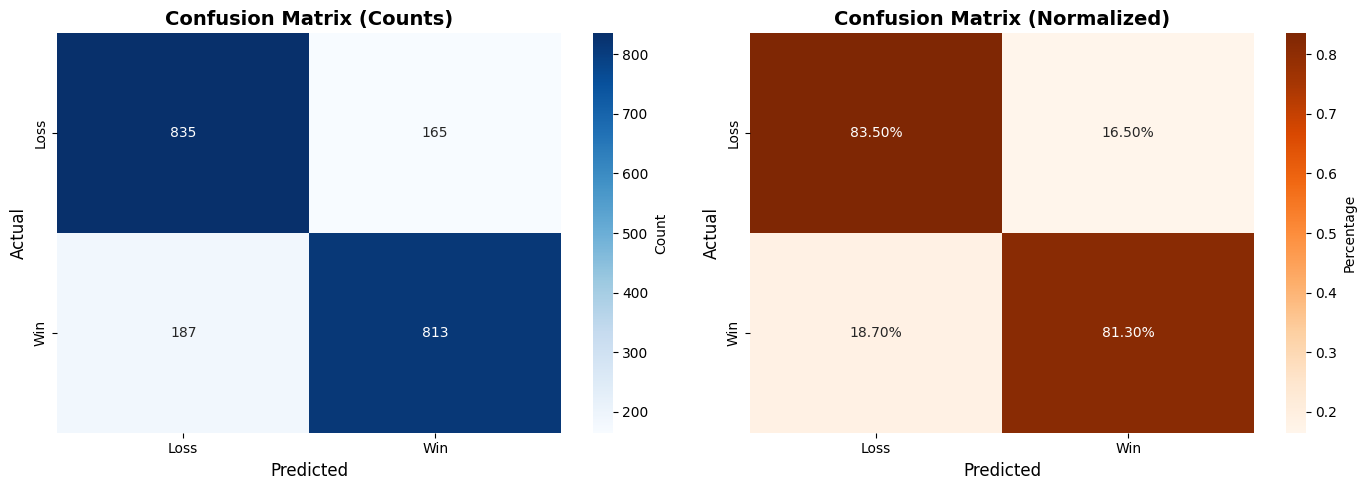

=== Analisi Dettagliata Performance su Holdout Set ===

Metriche di classificazione:
  Accuracy:  0.8240
  Precision: 0.8313 (quante predizioni 'win' sono corrette)
  Recall:    0.8130 (quante vittorie reali vengono catturate)
  F1-Score:  0.8220 (media armonica precision/recall)

Matrice di Confusione:
                 Predicted
              Loss    Win
Actual Loss    835    165
       Win     187    813

Interpretazione:
  True Negatives  (TN):  835 - Correttamente predette come Loss
  False Positives (FP):  165 - Erroneamente predette come Win
  False Negatives (FN):  187 - Erroneamente predette come Loss
  True Positives  (TP):  813 - Correttamente predette come Win

✅ Grafico salvato come 'confusion_matrix.png'

✅ Grafico salvato come 'confusion_matrix.png'


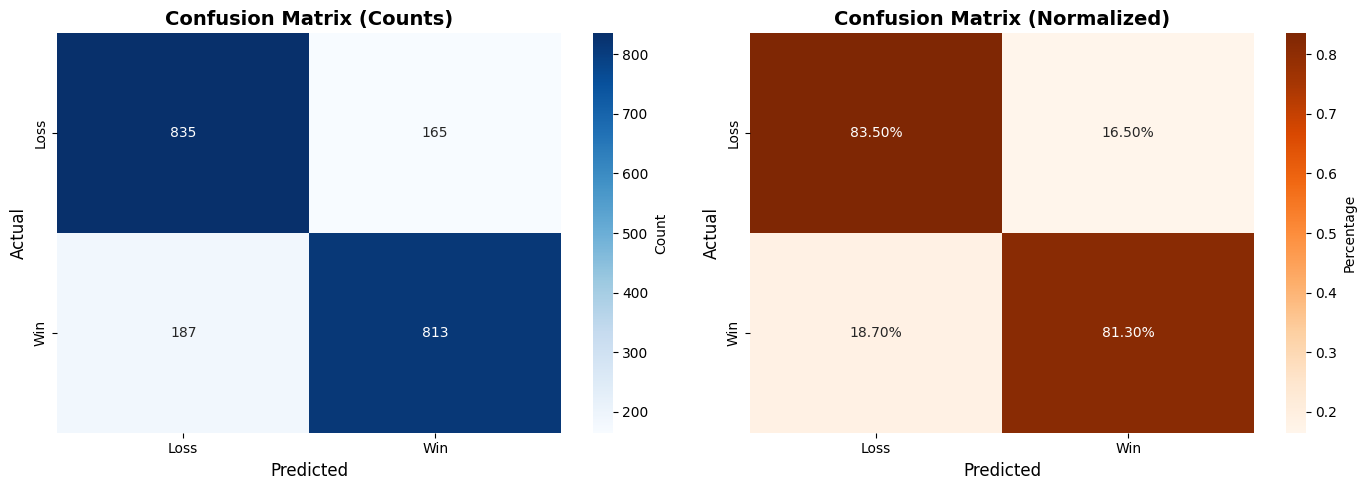


Classification Report Dettagliato:
              precision    recall  f1-score   support

    Loss (0)     0.8170    0.8350    0.8259      1000
     Win (1)     0.8313    0.8130    0.8220      1000

    accuracy                         0.8240      2000
   macro avg     0.8242    0.8240    0.8240      2000
weighted avg     0.8242    0.8240    0.8240      2000

✅ Grafico salvato come 'probability_distribution.png'
✅ Grafico salvato come 'probability_distribution.png'


=== Analisi Dettagliata Performance su Holdout Set ===

Metriche di classificazione:
  Accuracy:  0.8240
  Precision: 0.8313 (quante predizioni 'win' sono corrette)
  Recall:    0.8130 (quante vittorie reali vengono catturate)
  F1-Score:  0.8220 (media armonica precision/recall)

Matrice di Confusione:
                 Predicted
              Loss    Win
Actual Loss    835    165
       Win     187    813

Interpretazione:
  True Negatives  (TN):  835 - Correttamente predette come Loss
  False Positives (FP):  165 - Erroneamente predette come Win
  False Negatives (FN):  187 - Erroneamente predette come Loss
  True Positives  (TP):  813 - Correttamente predette come Win

✅ Grafico salvato come 'confusion_matrix.png'

✅ Grafico salvato come 'confusion_matrix.png'


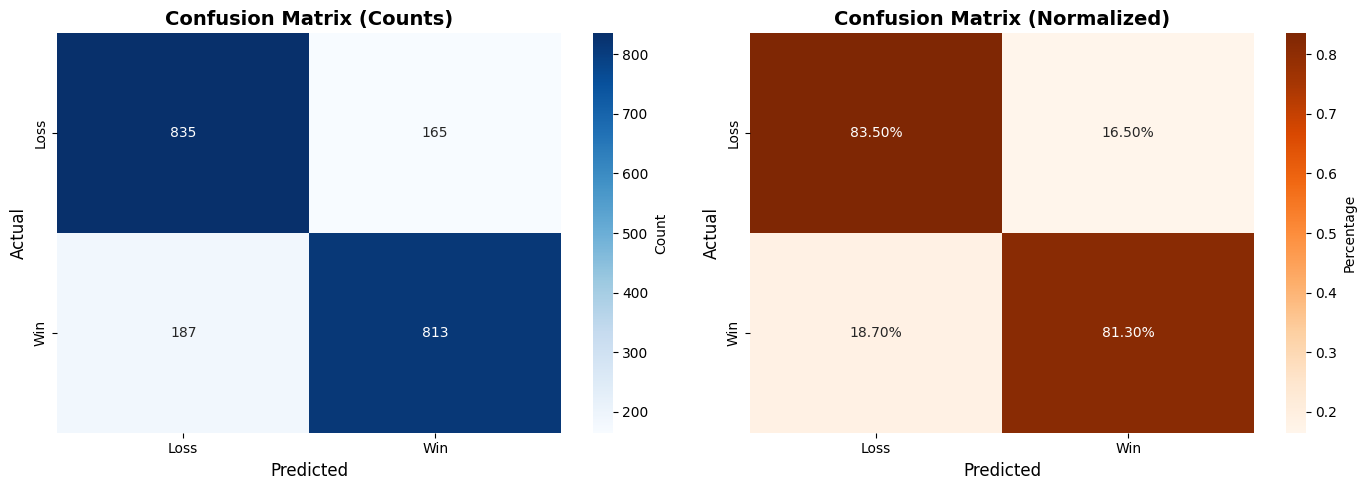


Classification Report Dettagliato:
              precision    recall  f1-score   support

    Loss (0)     0.8170    0.8350    0.8259      1000
     Win (1)     0.8313    0.8130    0.8220      1000

    accuracy                         0.8240      2000
   macro avg     0.8242    0.8240    0.8240      2000
weighted avg     0.8242    0.8240    0.8240      2000

✅ Grafico salvato come 'probability_distribution.png'
✅ Grafico salvato come 'probability_distribution.png'


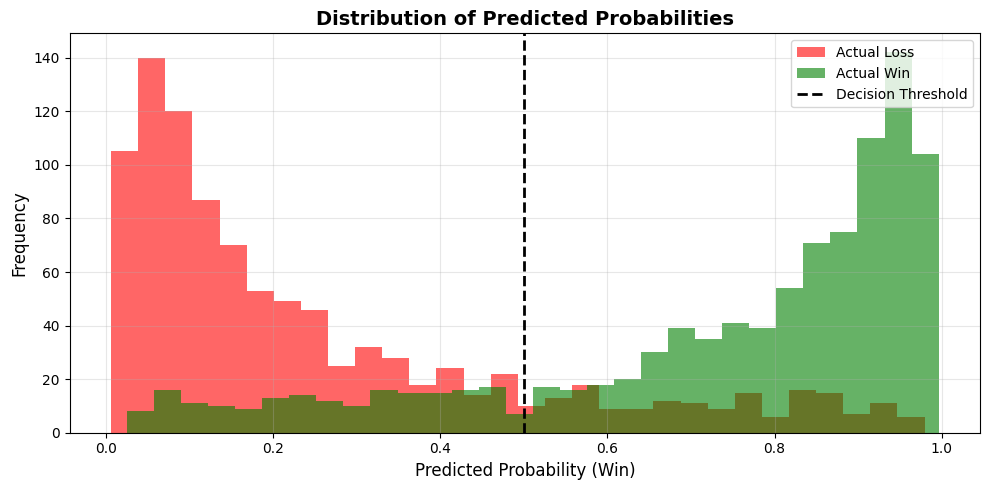

In [50]:
# === Matrice di Confusione e Metriche Dettagliate ===
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Analisi Dettagliata Performance su Holdout Set ===\n")

# Calcola matrice di confusione
cm = confusion_matrix(y_holdout, y_hold_pred)

# Metriche dettagliate
precision = precision_score(y_holdout, y_hold_pred)
recall = recall_score(y_holdout, y_hold_pred)
f1 = f1_score(y_holdout, y_hold_pred)

print("Metriche di classificazione:")
print(f"  Accuracy:  {hold_acc:.4f}")
print(f"  Precision: {precision:.4f} (quante predizioni 'win' sono corrette)")
print(f"  Recall:    {recall:.4f} (quante vittorie reali vengono catturate)")
print(f"  F1-Score:  {f1:.4f} (media armonica precision/recall)")

print("\nMatrice di Confusione:")
print(f"                 Predicted")
print(f"              Loss    Win")
print(f"Actual Loss   {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Win    {cm[1,0]:4d}   {cm[1,1]:4d}")

print(f"\nInterpretazione:")
print(f"  True Negatives  (TN): {cm[0,0]:4d} - Correttamente predette come Loss")
print(f"  False Positives (FP): {cm[0,1]:4d} - Erroneamente predette come Win")
print(f"  False Negatives (FN): {cm[1,0]:4d} - Erroneamente predette come Loss")
print(f"  True Positives  (TP): {cm[1,1]:4d} - Correttamente predette come Win")

# Visualizzazione grafica della matrice di confusione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Matrice di confusione con valori assoluti
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Loss', 'Win'], 
            yticklabels=['Loss', 'Win'],
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Plot 2: Matrice di confusione normalizzata (percentuali)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=['Loss', 'Win'], 
            yticklabels=['Loss', 'Win'],
            cbar_kws={'label': 'Percentage'},
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato come 'confusion_matrix.png'")
plt.show()

# Classification Report dettagliato
print("\n" + "="*60)
print("Classification Report Dettagliato:")
print("="*60)
print(classification_report(y_holdout, y_hold_pred, 
                          target_names=['Loss (0)', 'Win (1)'],
                          digits=4))

# Calcola anche le probabilità per analisi aggiuntiva
y_hold_proba = final_model.predict_proba(X_holdout)[:, 1]

# Distribuzione delle probabilità predette
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(y_hold_proba[y_holdout == 0], bins=30, alpha=0.6, label='Actual Loss', color='red')
ax.hist(y_hold_proba[y_holdout == 1], bins=30, alpha=0.6, label='Actual Win', color='green')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax.set_xlabel('Predicted Probability (Win)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=150, bbox_inches='tight')
print("✅ Grafico salvato come 'probability_distribution.png'")
plt.show()

=== ROC/AUC ===
AUC: 0.8926
Soglia Youden:  0.536   | Punto ROC: (FPR=0.151, TPR=0.800)
Soglia Closest: 0.506 | Punto ROC: (FPR=0.165, TPR=0.813)

--- 0.5 ---
CM:
[[835 165]
 [187 813]]
Accuracy:   0.8240  | Precision: 0.8313  | Recall: 0.8130  | Specificity: 0.8350  | F1: 0.8220

--- Youden --- (thr Youden)
CM:
[[849 151]
 [200 800]]
Accuracy:   0.8245  | Precision: 0.8412  | Recall: 0.8000  | Specificity: 0.8490  | F1: 0.8201

--- Closest --- (thr Closest)
CM:
[[835 165]
 [187 813]]
Accuracy:   0.8240  | Precision: 0.8313  | Recall: 0.8130  | Specificity: 0.8350  | F1: 0.8220

==> Soglia consigliata: 0.5 = 0.500 (criterio: F1 poi Accuracy)

✅ ROC salvata come 'roc_curve.png'


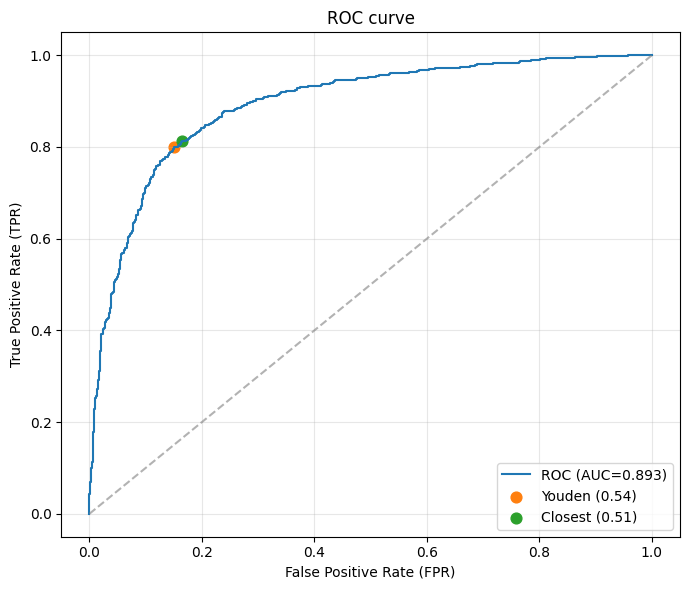

In [ ]:
# ROC, AUC e soglia ottimale (Youden e punto più vicino a (0,1))
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

# Probabilità (riusa se già calcolate)
try:
    y_probs = y_hold_proba
except NameError:
    y_probs = final_model.predict_proba(X_holdout)[:, 1]

# Curva ROC e AUC
fpr, tpr, thr = roc_curve(y_holdout, y_probs)
auc = roc_auc_score(y_holdout, y_probs)

# Soglia di Youden (max TPR - FPR)
youden = tpr - fpr
idx_youden = int(np.argmax(youden))
thr_youden = float(thr[idx_youden])

# Soglia più vicina a (0,1) (min distanza euclidea)
dist = np.sqrt((1 - tpr)**2 + (fpr**2))
idx_closest = int(np.argmin(dist))
thr_closest = float(thr[idx_closest])

def eval_at_threshold(th):
    yp = (y_probs >= th).astype(int)
    cm = confusion_matrix(y_holdout, yp)
    TN, FP, FN, TP = cm.ravel()
    acc = (TP + TN) / (TP + TN + FP + FN + 1e-12)
    prec = precision_score(y_holdout, yp, zero_division=0)
    rec = recall_score(y_holdout, yp, zero_division=0)  # TPR
    spec = TN / (TN + FP + 1e-12)
    f1 = f1_score(y_holdout, yp, zero_division=0)
    return cm, acc, prec, rec, spec, f1

# Confronto soglie standard
cm_05, acc_05, prec_05, rec_05, spec_05, f1_05 = eval_at_threshold(0.5)
cm_y, acc_y, prec_y, rec_y, spec_y, f1_y = eval_at_threshold(thr_youden)
cm_c, acc_c, prec_c, rec_c, spec_c, f1_c = eval_at_threshold(thr_closest)

# Soglia che massimizza l'Accuracy
acc_curve = []
for t in thr:
    yp = (y_probs >= t).astype(int)
    acc_curve.append(((yp == y_holdout).mean()))
idx_acc = int(np.argmax(acc_curve))
thr_acc = float(thr[idx_acc])

# Esporta la soglia migliore per Accuracy
DECISION_THRESHOLD = thr_acc

print('=== ROC/AUC ===')
print(f'AUC: {auc:.4f}')
print(f'Soglia Youden:  {thr_youden:.3f}   | Punto ROC: (FPR={fpr[idx_youden]:.3f}, TPR={tpr[idx_youden]:.3f})')
print(f'Soglia Closest: {thr_closest:.3f} | Punto ROC: (FPR={fpr[idx_closest]:.3f}, TPR={tpr[idx_closest]:.3f})')
print(f'Best accuracy threshold: {DECISION_THRESHOLD:.3f} | Acc={acc_curve[idx_acc]:.4f}')

def print_metrics(tag, cm, acc, prec, rec, spec, f1):
    TN, FP, FN, TP = cm.ravel()
    print(f"\n--- {tag} ---")
    print(f'CM:\n{cm}')
    print(f'Accuracy:   {acc:.4f}  | Precision: {prec:.4f}  | Recall: {rec:.4f}  | Specificity: {spec:.4f}  | F1: {f1:.4f}')

print_metrics('0.5', cm_05, acc_05, prec_05, rec_05, spec_05, f1_05)
print_metrics('Youden', cm_y, acc_y, prec_y, rec_y, spec_y, f1_y)
print_metrics('Closest', cm_c, acc_c, prec_c, rec_c, spec_c, f1_c)

print(f"\n==> Soglia consigliata (per Accuracy): {DECISION_THRESHOLD:.3f}")

# Plot ROC con punti evidenziati
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})', color='tab:blue')
plt.scatter([fpr[idx_youden]], [tpr[idx_youden]], c='tab:orange', s=60, label=f'Youden ({thr_youden:.2f})')
plt.scatter([fpr[idx_closest]], [tpr[idx_closest]], c='tab:green', s=60, label=f'Closest ({thr_closest:.2f})')
plt.plot([0,1],[0,1],'--', color='gray', alpha=0.6)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
print("\n✅ ROC salvata come 'roc_curve.png'")
plt.show()

In [ ]:
# Addestrare su tutto il train (tutti i 10000) con i
print("=== Training finale su TUTTO il dataset (10000 battaglie) ===")
X_full = train_df[FEATURES].values
y_full = train_df['player_won'].values

final_clf = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_clf.fit(X_full, y_full)

X_test = test_df[FEATURES].values
test_proba = final_clf.predict_proba(X_test)[:, 1]
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5
test_pred = (test_proba >= THR).astype(int)
print(f'Predictions threshold used: {THR:.3f}')

submission = pd.DataFrame({'battle_id': test_df['battle_id'].astype(int), 'player_won': test_pred})
submission.to_csv('submission.csv', index=False)
print("\nsubmission.csv creata. Prime righe:")
print(submission.head())
print(f"\nDistribuzione predizioni: {np.bincount(test_pred)}")

submission.csv creata. Prime righe:
   battle_id  player_won
0          0           0
1          1           1
2          2           1
3          3           1
4          4           1


## Analisi errori di predizione (holdout)

- Crea una tabella con predizioni errate sullo holdout
- Evidenzia FP/FN, probabilità, margine dalla soglia
- Salva su CSV e helper per ispezionare una partita

In [60]:
# Trova le partite sbagliate sullo holdout e ispezionale
import numpy as np
import pandas as pd

# Probabilità e soglia (riusa se già calcolate)
try:
    proba = y_hold_proba
except NameError:
    proba = final_model.predict_proba(X_holdout)[:, 1]
try:
    THR = DECISION_THRESHOLD
except NameError:
    THR = 0.5

# Costruisci DataFrame holdout con info utili
holdout_idx = pd.Index(idx_holdout)
holdout_meta = train_df.loc[holdout_idx, ['battle_id']].copy() if 'battle_id' in train_df.columns else pd.DataFrame(index=holdout_idx)
holdout_df = pd.DataFrame({
    'y_true': y_holdout.astype(int),
    'y_pred': y_hold_pred.astype(int),
    'proba_win': proba.astype(float),
}, index=holdout_idx)
holdout_df = holdout_meta.join(holdout_df)
holdout_df['error'] = (holdout_df['y_true'] != holdout_df['y_pred']).astype(int)
holdout_df['error_type'] = np.where(
    (holdout_df['y_true'] == 0) & (holdout_df['y_pred'] == 1), 'FP',
    np.where((holdout_df['y_true'] == 1) & (holdout_df['y_pred'] == 0), 'FN', 'OK')
)
holdout_df['margin'] = (holdout_df['proba_win'] - THR).abs()

# Solo errori
errors_df = holdout_df[holdout_df['error'] == 1].copy()

print('Totale holdout:', len(holdout_df))
print('Errori totali:', len(errors_df), '| FP:', (errors_df.error_type=='FP').sum(), '| FN:', (errors_df.error_type=='FN').sum())

# Errori più "confidenti" (grande distanza dalla soglia)
confident_errors = errors_df.sort_values('margin', ascending=False).head(20)
print('\nTop 20 errori più confidenti (lontani dalla soglia):')
display(confident_errors[['battle_id','y_true','y_pred','proba_win','error_type','margin']])

# Errori "borderline" (vicini alla soglia)
borderline_errors = errors_df.sort_values('margin', ascending=True).head(20)
print('\nTop 20 errori borderline (vicini alla soglia):')
display(borderline_errors[['battle_id','y_true','y_pred','proba_win','error_type','margin']])

# Salva su CSV per analisi offline
errors_df.to_csv('errors_holdout.csv', index=True)
print("\n✅ Salvato 'errors_holdout.csv' con tutte le predizioni errate dello holdout")

# Helper per ispezionare una partita (dai raw json) per battle_id
def inspect_battle(battle_id, max_turns=30):
    """Stampa un riassunto della partita dai raw json dati un battle_id (robusto a None)."""
    # Normalizza il tipo del battle_id (int se possibile)
    try:
        bid = int(battle_id)
    except Exception:
        bid = battle_id
    # Cerca in modo sicuro nei raw (ignora eventuali record None/non-dict)
    rec = next((r for r in train_raw if isinstance(r, dict) and r.get('battle_id') == bid), None)
    if rec is None:
        print('Battle non trovata nei raw train.')
        return
    p1 = rec.get('p1_team_details') or []
    p2 = rec.get('p2_team_details') or []
    p2_lead = rec.get('p2_lead_details') or {}
    print(f"battle_id: {rec.get('battle_id')} | player_won: {rec.get('player_won')}")
    print('p1 size:', len(p1), '| p2 size:', len(p2))
    if p1:
        lead = p1[0] or {}
        print('p1 lead:', lead.get('name'), lead.get('types'), 'lvl', lead.get('level'))
    if p2_lead:
        print('p2 lead:', p2_lead.get('name'), p2_lead.get('types'), 'lvl', p2_lead.get('level'))
    tl = (rec.get('battle_timeline') or [])[:max_turns]
    print(f'timeline turns (shown): {len(tl)}')
    # Stampa i primi 2 turni in modo sicuro
    for t in tl[:2]:
        t = t or {}
        p1_move = (t.get('p1_move_details') or {}).get('name')
        p2_move = (t.get('p2_move_details') or {}).get('name')
        print({'turn': t.get('turn'), 'p1_move': p1_move, 'p2_move': p2_move})

# Esempio: ispeziona il primo errore confidente
if not confident_errors.empty:
    example_bid = confident_errors.iloc[0]['battle_id'] if 'battle_id' in confident_errors.columns else None
    if example_bid is not None:
        print('\nEsempio ispezione prima partita con errore confidente:')
        inspect_battle(example_bid)

Totale holdout: 2000
Errori totali: 352 | FP: 165 | FN: 187

Top 20 errori più confidenti (lontani dalla soglia):


,battle_id,y_true,y_pred,proba_win,error_type,margin
5992,5992,0,1,0.979384,FP,0.479384
1409,1409,1,0,0.025429,FN,0.474571
6348,6348,0,1,0.972914,FP,0.472914
8874,8874,0,1,0.971186,FP,0.471186
9202,9202,0,1,0.965600,FP,0.465600
1001,1001,1,0,0.034843,FN,0.465157
3617,3617,1,0,0.036674,FN,0.463326
7891,7891,0,1,0.962728,FP,0.462728
9592,9592,0,1,0.962175,FP,0.462175
4567,4567,1,0,0.043167,FN,0.456833



Top 20 errori borderline (vicini alla soglia):


,battle_id,y_true,y_pred,proba_win,error_type,margin
7701,7701,0,1,0.508868,FP,0.008868
8054,8054,0,1,0.510952,FP,0.010952
9949,9949,0,1,0.511908,FP,0.011908
2984,2984,1,0,0.487583,FN,0.012417
4561,4561,1,0,0.486674,FN,0.013326
6757,6757,0,1,0.517144,FP,0.017144
3870,3870,1,0,0.481587,FN,0.018413
4239,4239,1,0,0.480624,FN,0.019376
2240,2240,1,0,0.479783,FN,0.020217
6944,6944,0,1,0.520821,FP,0.020821



✅ Salvato 'errors_holdout.csv' con tutte le predizioni errate dello holdout

Esempio ispezione prima partita con errore confidente:
battle_id: 5992 | player_won: False
p1 size: 6 | p2 size: 0
p1 lead: alakazam ['notype', 'psychic'] lvl 100
p2 lead: zapdos ['electric', 'flying'] lvl 100
timeline turns (shown): 30
{'turn': 1, 'p1_move': 'thunderwave', 'p2_move': None}
{'turn': 2, 'p1_move': 'psychic', 'p2_move': None}


## Peculiarità delle battaglie sbagliate: perché il modello sbaglia

Cosa fa questa sezione:
- Confronta le feature tra FP vs TN e FN vs TP (effect size).
- Analizza le spiegazioni locali con SHAP (errori vs corretti).
- Fornisce un helper per spiegare una singola partita (top feature che hanno spinto l’errore).

In [ ]:
# Analisi delle peculiarità degli errori (FP/FN) e motivazioni con SHAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prepara il dataset holdout con feature + etichette + meta
holdout_idx = pd.Index(idx_holdout)
Xh_df = pd.DataFrame(X_holdout, index=holdout_idx, columns=FEATURES)

try:
    proba = y_hold_proba
except NameError:
    proba = final_model.predict_proba(X_holdout)[:, 1]

meta_cols = ['battle_id'] if 'battle_id' in train_df.columns else []
meta = train_df.loc[holdout_idx, meta_cols].copy() if meta_cols else pd.DataFrame(index=holdout_idx)

hold_meta = pd.DataFrame({
    'y_true': y_holdout.astype(int),
    'y_pred': y_hold_pred.astype(int),
    'proba_win': proba.astype(float)
}, index=holdout_idx)
hold_meta['error_type'] = np.where(
    (hold_meta['y_true'] == 0) & (hold_meta['y_pred'] == 1), 'FP',
    np.where((hold_meta['y_true'] == 1) & (hold_meta['y_pred'] == 0), 'FN', 'OK')
)
H = meta.join(hold_meta).join(Xh_df)

FP = H[(H.y_true==0) & (H.y_pred==1)]   # falsi Win
TN = H[(H.y_true==0) & (H.y_pred==0)]   # Loss corretti
FN = H[(H.y_true==1) & (H.y_pred==0)]   # Win perse
TP = H[(H.y_true==1) & (H.y_pred==1)]   # Win corretti

# 2) Effect size (Cohen's d) per FP vs TN e FN vs TP
def cohen_d(a, b):
    a = a.astype(float); b = b.astype(float)
    ma, mb = np.nanmean(a), np.nanmean(b)
    sa, sb = np.nanstd(a, ddof=1), np.nanstd(b, ddof=1)
    n1, n2 = len(a), len(b)
    sp = np.sqrt(((n1-1)*sa*sa + (n2-1)*sb*sb) / max(n1+n2-2, 1))
    if sp == 0:
        return 0.0
    return (ma - mb) / sp

def rank_effects(group_a, group_b, label):
    rows = []
    for f in FEATURES:
        d = cohen_d(group_a[f], group_b[f])
        rows.append({'feature': f, 'cohens_d': d, 'pair': label})
    df = pd.DataFrame(rows).sort_values('cohens_d', key=np.abs, ascending=False)
    return df

fx_fp = rank_effects(FP, TN, 'FP_vs_TN')
fx_fn = rank_effects(FN, TP, 'FN_vs_TP')
diag_df = pd.concat([fx_fp.head(50), fx_fn.head(50)], ignore_index=True)
diag_df.to_csv('error_feature_diagnostics.csv', index=False)
print("✅ Salvato 'error_feature_diagnostics.csv' (top 50 per coppia).")

# Visualizza top 15 per ciascun confronto
print('\nTop 15 feature (|d|) per FP vs TN:')
display(fx_fp.head(15))
print('\nTop 15 feature (|d|) per FN vs TP:')
display(fx_fn.head(15))

# 3) SHAP analysis: errori vs corretti
try:
    import shap
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'shap', '-q'])
    import shap

explainer = shap.TreeExplainer(final_model)
shap_vals = explainer.shap_values(X_holdout)  # shape: (n, n_features)
if isinstance(shap_vals, list):
    shap_vals = shap_vals[1]  # compat per alcuni wrapper

idx_FP = FP.index.intersection(holdout_idx)
idx_TN = TN.index.intersection(holdout_idx)
idx_FN = FN.index.intersection(holdout_idx)
idx_TP = TP.index.intersection(holdout_idx)

abs_shap = np.abs(shap_vals)
mean_abs_shap_FP = abs_shap[holdout_idx.get_indexer(idx_FP)].mean(axis=0) if len(idx_FP)>0 else np.zeros(len(FEATURES))
mean_abs_shap_TN = abs_shap[holdout_idx.get_indexer(idx_TN)].mean(axis=0) if len(idx_TN)>0 else np.zeros(len(FEATURES))
mean_abs_shap_FN = abs_shap[holdout_idx.get_indexer(idx_FN)].mean(axis=0) if len(idx_FN)>0 else np.zeros(len(FEATURES))
mean_abs_shap_TP = abs_shap[holdout_idx.get_indexer(idx_TP)].mean(axis=0) if len(idx_TP)>0 else np.zeros(len(FEATURES))

diff_FP = mean_abs_shap_FP - mean_abs_shap_TN
diff_FN = mean_abs_shap_FN - mean_abs_shap_TP

shap_df_FP = pd.DataFrame({'feature': FEATURES, 'diff_mean_abs_shap': diff_FP}).sort_values('diff_mean_abs_shap', ascending=False)
shap_df_FN = pd.DataFrame({'feature': FEATURES, 'diff_mean_abs_shap': diff_FN}).sort_values('diff_mean_abs_shap', ascending=False)

print('\nTop 15 feature SHAP (error importance - correct) per FP:')
display(shap_df_FP.head(15))
print('\nTop 15 feature SHAP (error importance - correct) per FN:')
display(shap_df_FN.head(15))

# 4) Grafici sintetici
def plot_bar_top(df, value_col, title, fname, k=15):
    top = df.head(k)
    plt.figure(figsize=(8, max(4, k*0.35)))
    plt.barh(top['feature'][::-1], top[value_col][::-1], color='tab:blue')
    plt.title(title)
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    print(f"✅ Salvato '{fname}'")
    plt.show()

plot_bar_top(fx_fp.assign(abs_d=np.abs(fx_fp.cohens_d)).sort_values('abs_d', ascending=False), 'cohens_d', 'FP vs TN — Cohen\'s d', 'fp_vs_tn_effects.png')
plot_bar_top(fx_fn.assign(abs_d=np.abs(fx_fn.cohens_d)).sort_values('abs_d', ascending=False), 'cohens_d', 'FN vs TP — Cohen\'s d', 'fn_vs_tp_effects.png')
plot_bar_top(shap_df_FP, 'diff_mean_abs_shap', 'FP — Δ|SHAP| (error - correct)', 'fp_shap_diff.png')
plot_bar_top(shap_df_FN, 'diff_mean_abs_shap', 'FN — Δ|SHAP| (error - correct)', 'fn_shap_diff.png')

# 5) Spiegazione di una singola partita (per battle_id)
def explain_battle(battle_id, topk=10):
    if 'battle_id' not in H.columns:
        print('battle_id non disponibile in holdout.'); return
    rows = H.index[H['battle_id'] == battle_id]
    if len(rows)==0:
        print('battle_id non trovato nello holdout.'); return
    ridx = rows[0]
    xi = Xh_df.loc[ridx].values.reshape(1,-1)
    proba_i = float(final_model.predict_proba(xi)[:,1][0])
    pred_i = int(proba_i >= (globals().get('DECISION_THRESHOLD', 0.5)))
    true_i = int(H.loc[ridx, 'y_true'])
    etype = 'FP' if (true_i==0 and pred_i==1) else ('FN' if (true_i==1 and pred_i==0) else 'OK')
    sv = explainer.shap_values(xi)
    if isinstance(sv, list):
        sv = sv[1]
    sv = sv.reshape(-1)
    contrib = pd.DataFrame({'feature': FEATURES, 'shap': sv, 'abs_shap': np.abs(sv), 'value': Xh_df.loc[ridx, FEATURES].values})
    contrib = contrib.sort_values('abs_shap', ascending=False).head(topk)
    print(f"battle_id={battle_id} | y_true={true_i} | y_pred={pred_i} | proba={proba_i:.3f} | error_type={etype}")
    display(contrib[['feature','value','shap']])

print("\nSuggerimento:")
print("- Usa error_feature_diagnostics.csv per vedere le feature più associate a errori.")
print("- Chiama explain_battle(<battle_id>) per vedere le top feature che hanno spinto la predizione (SHAP).")